# Data Driven Gait Analysis

### TRA105 Digitalization in Sports

#### Group Members:
 - David Larsson
 - Savya Sachi Gupta
 
 ---
 ---
 
 In this notebook, we will be looking at two methods we employed to build models to identify 'Gait' in skiers.

##### Importing Libraries

In [1]:
from functions.dataframe_functions import *
from functions.analysis_setup_functions import *

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn import metrics
from imblearn.combine import SMOTETomek

##### Loading the Dataset

In [2]:
path_first = "../matlab_report-master/Treadmill/Test/Torsby/"
skier_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
path_second = "/CSV/csvData.csv"
filepath_list = [path_first + str(i) + path_second for i in skier_list]

main_df, df_peaks, df_info = get_dataframe(filepath_list, skier_list)

#### Run below cell only if you want to COMPLETELY exclude a few skiers from training data and use them for validation directly

In [74]:
# No. of Skiers to use for testing
validation_skiers = 3

X = df_info[df_info.columns.difference(['Pole', 'Other pole index', 'Gear','Peak time'])]
y = (df_info[['Gear','Skier']])

y_plot_data = df_info.loc[(df_info['Skier'] > (len(skier_list) - validation_skiers))]

X_train = X.loc[(X['Skier'] <= (len(skier_list) - validation_skiers))]
X_valid = X.loc[(X['Skier'] > (len(skier_list) - validation_skiers))]
y_train = y.loc[(y['Skier'] <= (len(skier_list) - validation_skiers))]
y_valid = y.loc[(y['Skier'] > (len(skier_list) - validation_skiers))]

X_train = X_train[X_train.columns.difference(['Skier'])]
X_valid = X_valid[X_valid.columns.difference(['Skier'])]
y_train = y_train[y_train.columns.difference(['Skier'])]
y_train = y_train.values.ravel()
y_valid = y_valid[y_valid.columns.difference(['Skier'])]
y_valid = y_valid.values.ravel()

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(12108, 6) (5103, 6) (12108,) (5103,)


---
---
---
# RANDOM FOREST CLASSIFIER
---

In [4]:
#-----------------------------------------------------------------------------------------
# SETTING UP PARAMETERS FOR HYPERPARAMETER TUNING
#-----------------------------------------------------------------------------------------
# Specifiying the range of Number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(start = 6, stop = 120, num = 6)]

# Specifying the range of Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_depth.append(None)

# Specifying the range of Minimum number of samples required to split a node
min_samples_split = [1, 2, 4, 6]

# Specifying the range of Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]

# Specifying the Method of selecting samples for training each tree
bootstrap = [True, False]

# Specifying the Class weight
class_weight = ['balanced', 'balanced_subsample']

# Now, we create the random grid that would store all the values as specified above
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'class_weight' : class_weight
              }


#-----------------------------------------------------------------------------------------
# PERFORMING HYPERPARAMETER TUNING
#-----------------------------------------------------------------------------------------
# Now, using the random grid created above, we start to search for the best hyperparameters

# First we create the base model that we want to tune by specifying no parameters
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 50, scoring='balanced_accuracy', 
                              cv = 3, verbose=2,
                               # random_state=42,
                               n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

print('Best Parameters after Randomized Search CV : ')
print(rf_random.best_params_)
print('\n')

#-----------------------------------------------------------------------------------------
# EVALUATE MODEL WITH CHOSEN PARAMETERS
#-----------------------------------------------------------------------------------------
# Build the Random Forest Classifier model based on best set of parameters chosen above
rfc = rf_random.best_estimator_

print('Final List of Parameters of the Classifier:')
print(rfc.get_params())
print('\n')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.7min finished


Best Parameters after Randomized Search CV : 
{'n_estimators': 74, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': True}


Final List of Parameters of the Classifier:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 6, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 74, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}




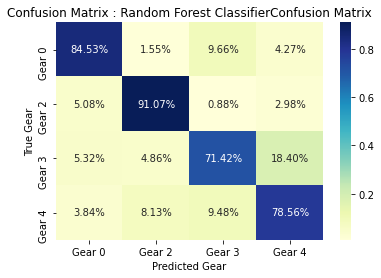

Performance Metrics for Random Forest Classifier :
----------------------------------------------------------
Accuracy Score: 0.7971781305114638
Balanced Accuracy Score: 0.8139342662252118
Precision: (Macro Avg) 0.7391415643790057
Recall: (Macro Avg) 0.8139342662252118
F-1 Score (Macro Avg): 0.7597125998776573
MCC Score: 0.7108037445895514
Mean Absolute Error: 0.41034685479129923
Mean Squared Error: 1.0738781109151478
Root Mean Squared Error: 1.0362809034789495
Classifier Score: 0.6413874191651969

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.85      0.88      2133
           2       0.76      0.91      0.83       571
           3       0.85      0.71      0.77      1956
           4       0.43      0.79      0.55       443

    accuracy                           0.80      5103
   macro avg       0.74      0.81      0.76      5103
weighted avg       0.83      0.80      0.81      5103



In [140]:
# Fit the model with training data
rfc.fit(X_train, y_train)

# Evluate the model using validation data and output performance metrics
results, all_y_pred, CM_arr = evaluate(rfc,X_valid, y_valid, 'Random Forest Classifier')

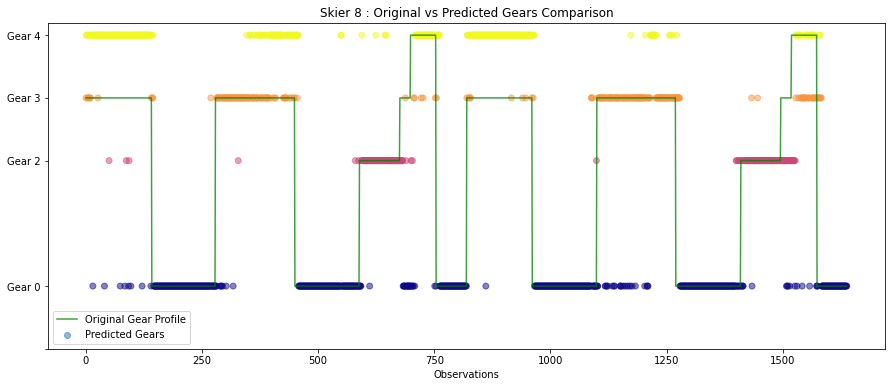

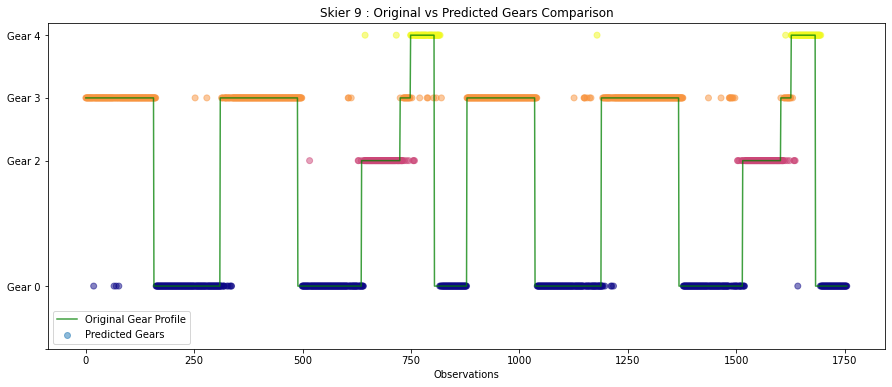

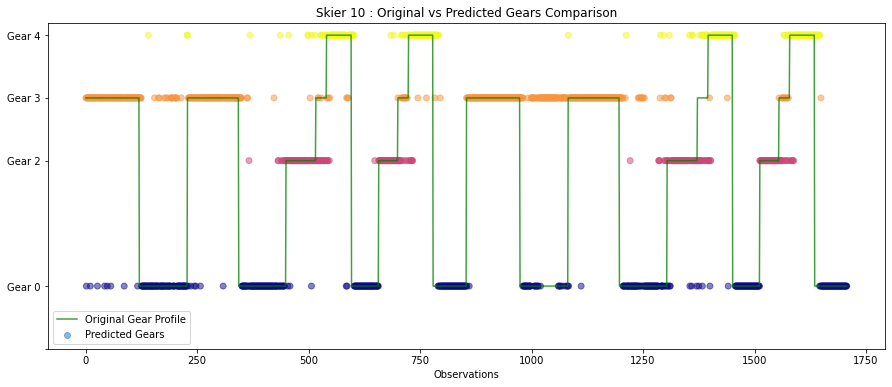

In [141]:
plot_df = y_plot_data
plot_df = plot_df.assign(Predicted_Gear=all_y_pred)
skier_list = plot_df['Skier'].unique()


for i in range(0,len(skier_list)):
    temp_df = plot_df.loc[(plot_df['Skier'] == skier_list[i])]

    fig, axs = plt.subplots(figsize=(15,6))
    plt.title(f'Skier {skier_list[i]} : Original vs Predicted Gears Comparison')
    plt.xlabel('Observations')
    plt.plot(range(0,temp_df.shape[0]), temp_df['Gear'],alpha=0.75, color='green', label='Original Gear Profile')
    plt.scatter(range(0,temp_df.shape[0]), temp_df['Predicted_Gear'],alpha=0.5, c=temp_df.Predicted_Gear, cmap='plasma', label='Predicted Gears')
    axs.set_yticks([-1,0,2,3,4])
    axs.set_yticklabels(['','Gear 0', 'Gear 2', 'Gear 3', 'Gear 4'])
    plt.legend(loc='lower left')
    plt.show()

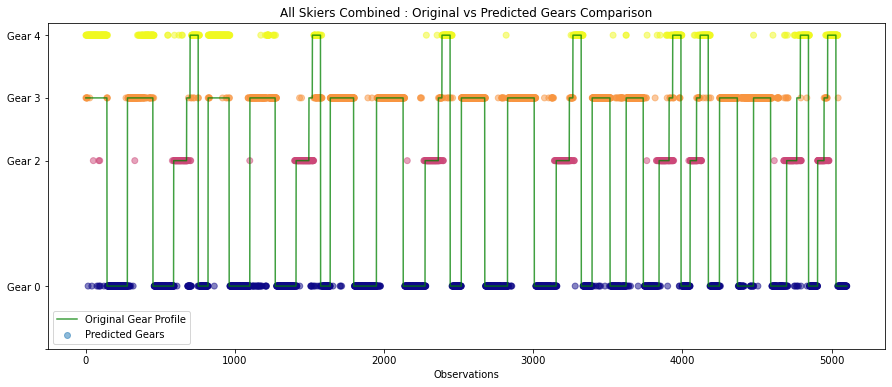

In [142]:
temp_df = plot_df

fig, axs = plt.subplots(figsize=(15,6))
plt.title(f'All Skiers Combined : Original vs Predicted Gears Comparison')
plt.xlabel('Observations')
plt.plot(range(0,temp_df.shape[0]), temp_df['Gear'],alpha=0.75, color='green', label='Original Gear Profile')
plt.scatter(range(0,temp_df.shape[0]), temp_df['Predicted_Gear'],alpha=0.5, c=temp_df.Predicted_Gear, cmap='plasma', label='Predicted Gears')
axs.set_yticks([-1,0,2,3,4])
axs.set_yticklabels(['','Gear 0', 'Gear 2', 'Gear 3', 'Gear 4'])
plt.legend(loc='lower left')
plt.show()

---
---
---
# Multiclass Logistic Regression
---

### Hyperparameter Tuning for Logistic Regression

In [6]:
#-----------------------------------------------------------------------------------------
# SETTING UP PARAMETERS FOR HYPERPARAMETER TUNING
#-----------------------------------------------------------------------------------------
# Create regularization penalty space
penalty = ['l1', 'l2', 'elasticnet']

# Specify if Dual or primal formulation
dual=[True,False]

# Create regularization hyperparameter space
C = np.logspace(0, 2.5, 15)

# define grid for different class weights
balance=['balanced']

#Specify the solver
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Specifying the range of maximum oterations to enable convergence
max_iter = np.linspace(100, 10000, 100).astype(int)

param_grid = dict(dual=dual, class_weight=balance, C=C, solver=solver, penalty=penalty, max_iter=max_iter)


#-----------------------------------------------------------------------------------------
# PERFORMING HYPERPARAMETER TUNING
#-----------------------------------------------------------------------------------------
# Now, using the random grid created above, we start to search for the best hyperparameters

# First we create the base model that we want to tune by specifying no parameters
lr = LogisticRegression()

lr_random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid,
                               n_jobs=-1, scoring='balanced_accuracy', cv = 3,
                              return_train_score=True)

#lr_random_result = lr_random.fit(X_train, y_train)
lr_random.fit(X_train, y_train)


print('Best Parameters after Randomized Search CV : ')
print(lr_random.best_params_)
print('\n')

#-----------------------------------------------------------------------------------------
# EVALUATE MODEL WITH CHOSEN PARAMETERS
#-----------------------------------------------------------------------------------------
# Build the Random Forest Classifier model based on best set of parameters chosen above
lr = lr_random.best_estimator_

print('Final List of Parameters of the Classifier:')
print(lr.get_params())
print('\n')

Best Parameters after Randomized Search CV : 
{'solver': 'sag', 'penalty': 'l2', 'max_iter': 1800, 'dual': False, 'class_weight': 'balanced', 'C': 1.0}


Final List of Parameters of the Classifier:
{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1800, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'sag', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}




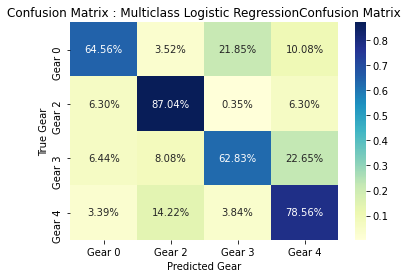

Performance Metrics for Multiclass Logistic Regression :
----------------------------------------------------------
Accuracy Score: 0.6762688614540466
Balanced Accuracy Score: 0.7324621445358155
Precision: (Macro Avg) 0.6409609023026432
Recall: (Macro Avg) 0.7324621445358155
F-1 Score (Macro Avg): 0.6535323447059581
MCC Score: 0.5560799385713011
Mean Absolute Error: 0.7321183617479914
Mean Squared Error: 2.051342347638644
Root Mean Squared Error: 1.4322507977441117
Classifier Score: 0.6819517930629042

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.65      0.75      2133
           2       0.63      0.87      0.73       571
           3       0.72      0.63      0.67      1956
           4       0.33      0.79      0.47       443

    accuracy                           0.68      5103
   macro avg       0.64      0.73      0.65      5103
weighted avg       0.74      0.68      0.69      5103



In [136]:
# Fit the model with training data
lr.fit(X_train, y_train)

# Evluate the model using validation data and output performance metrics
results, all_y_pred, CM_arr = evaluate(lr, X_valid, y_valid, 'Multiclass Logistic Regression')

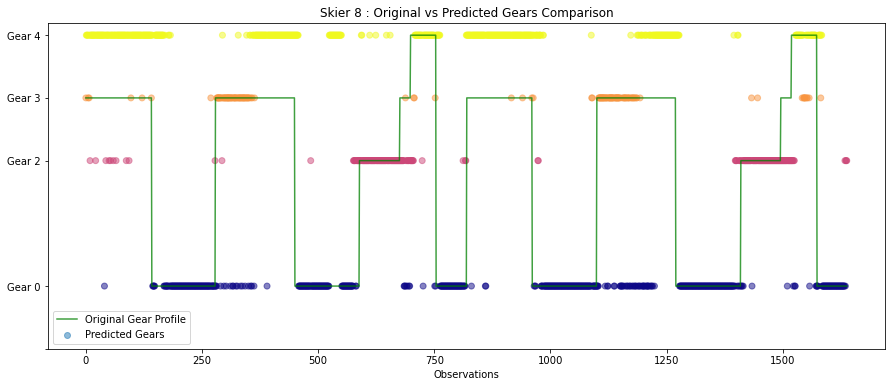

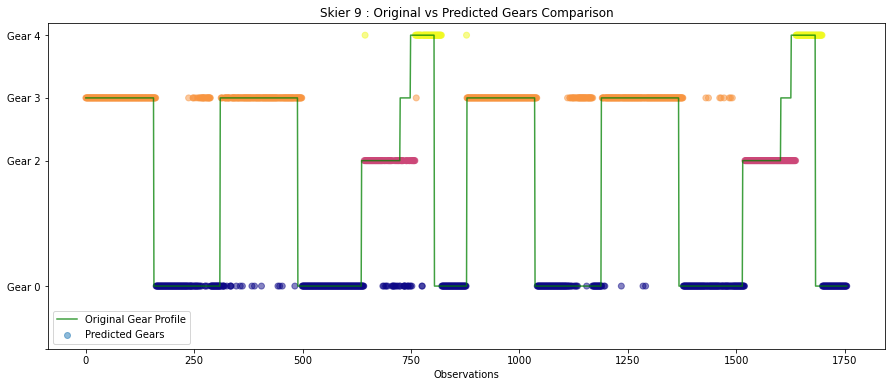

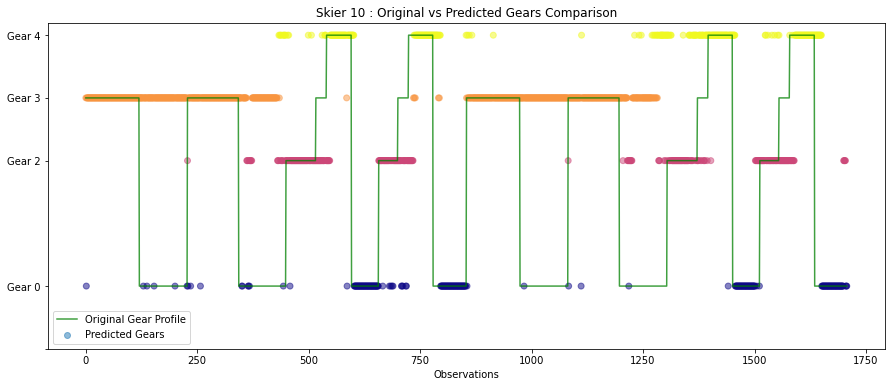

In [137]:
plot_df = y_plot_data
plot_df = plot_df.assign(Predicted_Gear=all_y_pred)
skier_list = plot_df['Skier'].unique()


for i in range(0,len(skier_list)):
    temp_df = plot_df.loc[(plot_df['Skier'] == skier_list[i])]

    fig, axs = plt.subplots(figsize=(15,6))
    plt.title(f'Skier {skier_list[i]} : Original vs Predicted Gears Comparison')
    plt.xlabel('Observations')
    plt.plot(range(0,temp_df.shape[0]), temp_df['Gear'],alpha=0.75, color='green', label='Original Gear Profile')
    plt.scatter(range(0,temp_df.shape[0]), temp_df['Predicted_Gear'],alpha=0.5, c=temp_df.Predicted_Gear, cmap='plasma', label='Predicted Gears')
    axs.set_yticks([-1,0,2,3,4])
    axs.set_yticklabels(['','Gear 0', 'Gear 2', 'Gear 3', 'Gear 4'])
    plt.legend(loc='lower left')
    plt.show()

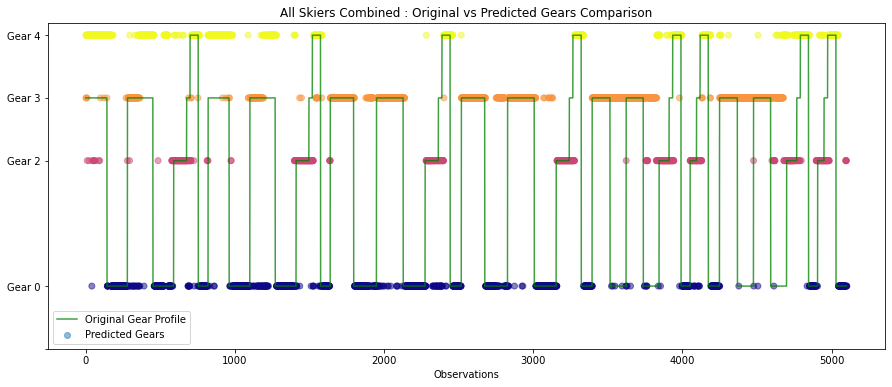

In [139]:
temp_df = plot_df

fig, axs = plt.subplots(figsize=(15,6))
plt.title(f'All Skiers Combined : Original vs Predicted Gears Comparison')
plt.xlabel('Observations')
plt.plot(range(0,temp_df.shape[0]), temp_df['Gear'],alpha=0.75, color='green', label='Original Gear Profile')
plt.scatter(range(0,temp_df.shape[0]), temp_df['Predicted_Gear'],alpha=0.5, c=temp_df.Predicted_Gear, cmap='plasma', label='Predicted Gears')
axs.set_yticks([-1,0,2,3,4])
axs.set_yticklabels(['','Gear 0', 'Gear 2', 'Gear 3', 'Gear 4'])
plt.legend(loc='lower left')
plt.show()